<font color='darkblue'><h1><p style="text-align: center;"><strong>Project | ACCENT RECOGNITION</strong></p></h1></font>

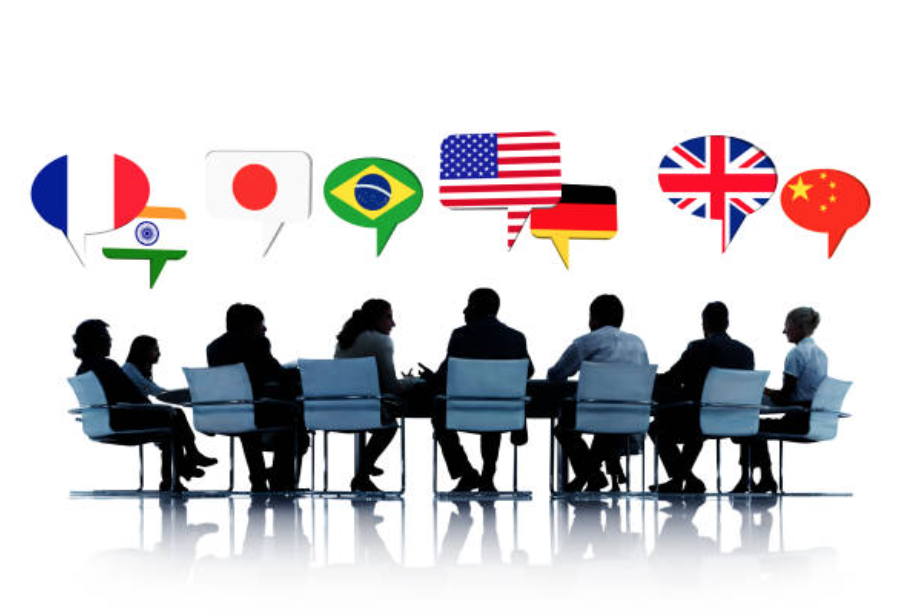

<ins><strong>Objective: </strong></ins>

Native and non-native speakers of English read the same paragraph and are carefully transcribed.
<br>Our goal is to compare, analyze and predict the accents of different English speakers.

The elicitation <strong>paragraph</strong> is the following:

_"Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."_

In [1]:
import IPython as ip
ip.display.Audio(r"https://accent.gmu.edu/soundtracks/french8.mp3")

<ins><strong>Sources: </strong></ins>

- The <strong><font color='purple'> Speech Accent Archive website</font></strong>:    https://accent.gmu.edu/
- The Kaggle <strong><font color='purple'>  Speech Accent Archive dataset</font></strong>:   https://www.kaggle.com/datasets/rtatman/speech-accent-archive
<br>_Weinberger, S. (2013). Speech accent archive. George Mason University_.
_Datasets distributed under a CC BY-NC-SA 2.0 license._

<ins><strong>Source: </strong></ins>

In [5]:
ml_dataset          = '../data/bios.csv'

##  <font color='DarkBlue'> <ins> Machine Learning</ins>: <font color='blue'></font>

### <font color='MediumBlue'><ins> Overall Workflow</ins>: <font color='violet'></font>

0. **Data Preprocessing**:
   - **Data Loading** 
   - **Labeling**
   - **Truncation**
   - **Extracting Features** 
      - **Mel-Frequency Cepstral Coefficients (MFCCs)**
   - **Data Splitting**
   - **Normalization**:
4. **Selecting Model(s)**:
   - **Convolutional Neural Networks (CNNs)**
   - **Recurrent Neural Networks (RNNs)**
5. **Training**
6. **Evaluating**
7. **Deploying & Predicting**

### <font color='MediumBlue'>0 - <ins> Data preprocessing</ins>: <font color='violet'></font>

There is a need to "represent" audio data and prepare it for input into machine learning models. 
This preparatory work consists in:

   - **Data Loading**: <br>Loading the mp3 audio files from their storage location ( <font color='red'>../soundtracks/</font>*.MP3 )

In [3]:
import julestools as jt
import pandas as pd
import numpy as np
import librosa

df = pd.read_csv('../data/bios.csv')
df['language'] = '../soundtracks/' + df['language'] + '.mp3'

   - **Labeling**:<br>Consist in assigning a label for each recording with the native language of the speaker. 

In [4]:
df.rename(columns= {'language': 'recording','native language': 'native_language'}, inplace=True)

df[['recording','native_language']].head(3)

,recording,native_language
0,../soundtracks/afrikaans1.mp3,afrikaans
1,../soundtracks/afrikaans2.mp3,afrikaans
2,../soundtracks/agni1.mp3,agni


   - **Resampling**:<br>Ensuring that all audio samples have the same sample rate, which is required for some models such as RNNs , which expect inputs of consistent length.

In [1]:
# Already included in the previous extracting features function

# Resampling at 22050 Hz)
# audio, sr = librosa.load('path_to_your_audio_file.mp3', sr=22050)

   - **Extracting Features**:

Extracting features from the audio data to represent them in a suitable format for machine learning models, including spectral features like MFCCs - Mel-Frequency Cepstral Coefficients, spectrograms, or other representations of the audio signal such as:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<strong>Mel-Frequency Cepstral Coefficients (MFCCs)</strong>: <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Which is a representation of the short-term power spectrum of a sound.

In [ ]:
# Definining the target duration as the length of the shortest recording in the dataset
target_duration = min(librosa.get_duration(filename) for filename in df['recording'])

# Calculating the number of frames (num_frames) based on the target_duration and frame rate used for MFCC extraction

frame_rate = 100  # This can be adjusted
num_frames = int(target_duration * frame_rate)

# Define function for feature extraction with truncation
def extract_features(filename, ,target_sr=22050, target_duration):
    try:
        # Loading audio file using librosa and resampling to the target sample rate of 22050
        audio, sr = librosa.load(filename, sr=target_sr)
        
        # Truncate or pad audio to the target duration
        target_length = int(target_duration * sr)
        audio = audio[:target_length]
        
        # Extract features (MFCCs) using librosa
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        return mfccs
    
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None

# Apply feature extraction function to each row in the dataframe
df['features'] = df['recording'].apply(lambda x: extract_features(x, target_duration))

# Drop rows with missing features (if any)
df.dropna(subset=['features'], inplace=True)

# Split the dataframe into features (X) and labels (y)
X = np.array(df['features'].tolist())
y = df['native_language']

   - **Truncation**: Since RNNs expects inputs of fixed length, we will truncate to a specified length.

In [ ]:
# Definining the target duration as the length of the shortest recording in the dataset
#target_duration = min(librosa.get_duration(filename) for filename in df['recording'])

# We already conduct this task within the Feature extracting function
# target_length = int(target_duration * sr)
# audio = audio[:target_length]

   - **Data Splitting**: Split the dataset into training, validation, and test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Spliting the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# Spliting the training data into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=666)

   - **Normalization**: Scaling the extracted features to a common range to ensure numerical stability during training.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fiting and transforming on training data
X_train_normalized = scaler.fit_transform(X_train)

# Transforming validation and test data
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

Consist in assigning a label for each recording with the native language of the speaker. We do have already these labels at our disposal in saa_bios dataset.

### <font color='MediumBlue'>1 - <ins> Selecting Model(s)</ins>: <font color='violet'></font>

Many machine learning models for classification could be leveraged here. We might not test all of them but the following ones are to be considered in our workflow:

   - **Convolutional Neural Networks (CNNs)**
   - **Recurrent Neural Networks (RNNs)**

   - **Convolutional Neural Networks (CNNs)**: These can be used directly on spectrogram representations of audio. Although it is commonly more efficient for images rather than for Audio.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Defining the CNN model
input_shape = (num_frames, num_features, 1)  # Assuming input audio features are in the shape (num_frames, num_features)

cnn = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
])

# Compiling the model
cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

   - **Recurrent Neural Networks (RNNs)**: Especially useful for sequential data like audio, where the order of the features matters.
   This is certainly our best candidate model test in our context.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# num_classes is the number of native languages
num_classes = df['native language'].nunique()

# Defining the RNN model
num_features = 13 # As per MFCC n_mfcc value

input_shape = (num_time_steps, num_features)

rnn = keras.Sequential([
    layers.LSTM(64, input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compiling the model
rnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### <font color='MediumBlue'>2 - <ins> Training</ins>: <font color='violet'></font>

Training our chosen model(s) on the training set and validating it using the validation set , tuning hyperparameters (and avoiding overfitting ).

   - **CNN**:

In [ ]:
cnn_fit = cnn.fit(X_train_normalized, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val_normalized, y_val))

   - **RNN**:

In [ ]:
rnn_fit = rnn.fit(X_train_normalized, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val_normalized, y_val))

### <font color='MediumBlue'>3 - <ins> Evaluating</ins>: <font color='violet'></font>

Evaluating the trained model on the test set to assess its performance in predicting the native language of speakers based on their accents. 

   - **CNN**:

In [ ]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(X_test_normalized, y_test)
print('Test accuracy:', cnn_test_acc)

   - **RNN**:

In [ ]:
rnn_test_loss, rnn_test_acc = rnn.evaluate(X_test_normalized, y_test)
print('Test accuracy:', rnn_test_acc)

### <font color='MediumBlue'>4 - <ins> Deploying & Predicting</ins>: <font color='violet'></font>

Deploying our model(s), and predicting the native language of speakers based on their accents in new recordings.